In [1]:

import os
import pickle
from scipy import signal
import libfmp.b
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks
from pydub.generators import Triangle

from compute_tempo import *

In [2]:
nn = 2
mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]
# annotation = ["BKO_E1_D1_01_Suku_Dancers.csv", "BKO_E1_D1_02_Maraka_Dancers.csv", "BKO_E1_D1_03_Wasulunka_Dancers.csv", "BKO_E1_D2_04_Maraka.csv"]
# cyclefile= ["BKO_E1_D1_01_Suku_C.csv", "BKO_E1_D1_02_Maraka_C.csv", "BKO_E1_D1_03_Wasulunka_C.csv", "BKO_E1_D2_04_Maraka_C.csv"]



file_path = f"./mocap_mvnx/{mvnfiles[nn]}"
file_name = os.path.basename(file_path).split(".")[0]
djembe_obj = djembe(file_path)

motiondata_section, _, _, _ = djembe_obj.load_djembe(frme=-1)



In [3]:
def filter_onsets_by_distance(xyz_ab_minima, xyz_ab, distance_threshold=0.1, time_threshold=0.8, fps=240):
    # Initialize the list to store filtered onsets
    filtered_onsets = []
    
    # Iterate through the onsets
    for i in range(len(xyz_ab_minima) - 1):
        onset_current = xyz_ab_minima[i]
        onset_next = xyz_ab_minima[i + 1]
        
        # Calculate the distance between the two onsets (in terms of velocity)
        distance = np.sum(np.abs(xyz_ab[onset_current:onset_next])) / fps
        
        # Compute time difference in frames
        time_diff = (onset_next-onset_current)/fps
        
        # Apply the distance threshold
        if distance > distance_threshold and time_diff <= time_threshold:
            # Keep the next onset
            filtered_onsets.append(onset_next)
    
    return np.array(filtered_onsets)


In [4]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT

mocap_fps = 240
segment_name = 'SEGMENT_LEFT_FOOT'
vel = motiondata_section['velocity'][segment_name]

N = len(vel)
time = (np.arange(N)/240)

x_ab = np.abs(savgol_filter(vel[:,0], 60, 0))
y_ab = np.abs(savgol_filter(vel[:,1], 60, 0))
z_ab = np.abs(savgol_filter(vel[:,2], 60, 0))


In [5]:
def velocity_based_novelty(data, order=15, distance_threshold=0.01, time_threshold=1.5, onset_threshold=0.5):
    minima_indices = argrelmin(data, order=order)[0]
    filtered_onsets = filter_onsets_by_distance(minima_indices, data, distance_threshold=distance_threshold, time_threshold=time_threshold)
    kept_onsets = filtered_onsets[data[filtered_onsets] < onset_threshold]   # filter out onsets based on velocity threshold
    binary_onset_data = np.zeros(len(data))
    binary_onset_data[kept_onsets] = 1
    return binary_onset_data

datax = velocity_based_novelty(x_ab)
datay = velocity_based_novelty(y_ab)
dataz = velocity_based_novelty(z_ab)



In [ ]:
# plt.figure(figsize=(100, 12), dpi=200)
# plt.plot(time, x_ab, linewidth=0.3)

# plt.figure(figsize=(100, 12), dpi=200)
# plt.plot(time, y_ab, linewidth=0.3)

# plt.figure(figsize=(100, 12), dpi=200)
# plt.plot(time, z_ab, linewidth=0.3)

plt.figure(figsize=(100, 12), dpi=100)
plt.plot(time, dataz, linewidth=0.3)
plt.plot(time, z_ab, linewidth=0.5)
plt.title(f'{segment_name}')
plt.show()

In [6]:


window_size = 240*5 #corresponding to 5 sec
hop_size = 10
tempi_range = np.arange(50,240,10)

xtempogram, xtime_axis_seconds, xtempo_axis_bpm = compute_tempogram_fourier(datax, mocap_fps, window_length=window_size, hop_size=hop_size, tempi=tempi_range)
xtempogram_ab = np.abs(xtempogram)

ytempogram, ytime_axis_seconds, ytempo_axis_bpm = compute_tempogram_fourier(datay, mocap_fps, window_length=window_size, hop_size=hop_size, tempi=tempi_range)
ytempogram_ab = np.abs(ytempogram)

ztempogram, ztime_axis_seconds, ztempo_axis_bpm = compute_tempogram_fourier(dataz, mocap_fps, window_length=window_size, hop_size=hop_size, tempi=tempi_range)
ztempogram_ab = np.abs(ztempogram)

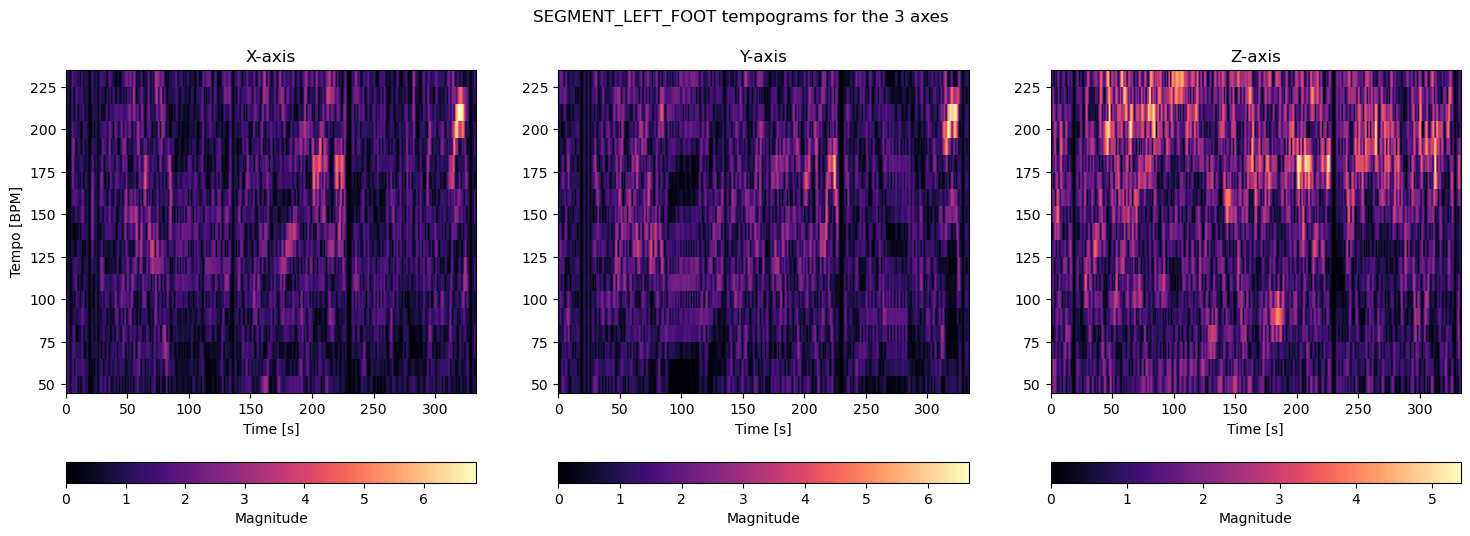

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Tempogram 1
cax1 = axs[0].pcolormesh(xtime_axis_seconds, xtempo_axis_bpm, xtempogram_ab, shading='auto', cmap='magma')
axs[0].set_title('X-axis')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Tempo [BPM]')
plt.colorbar(cax1, ax=axs[0], orientation='horizontal', label='Magnitude')

# Tempogram 2
cax2 = axs[1].pcolormesh(ytime_axis_seconds, ytempo_axis_bpm, ytempogram_ab, shading='auto', cmap='magma')
axs[1].set_title('Y-axis')
axs[1].set_xlabel('Time [s]')
plt.colorbar(cax2, ax=axs[1], orientation='horizontal', label='Magnitude')

# Tempogram 3
cax3 = axs[2].pcolormesh(ztime_axis_seconds, ztempo_axis_bpm, ztempogram_ab, shading='auto', cmap='magma')
axs[2].set_title('Z-axis')
axs[2].set_xlabel('Time [s]')
plt.colorbar(cax3, ax=axs[2], orientation='horizontal', label='Magnitude')
plt.suptitle(f'{segment_name} tempograms for the 3 axes')
plt.show()

In [ ]:
plt.figure(figsize=(100, 12), dpi=100)

plt.plot(time, x_ab, label='X', linewidth=0.4)
plt.scatter(xkept_onsets/240, x_ab[xkept_onsets], color='red', label='Directional Changes', zorder=5, s=4)
# plt.hlines(y=np.array([0.982, 0.676 +3, 0.646 +6]), xmin=0.0, xmax=N/240, color='r', linestyle='dotted', linewidth=0.3)
# plt.vlines(x=np.array([100, 101.5, 102, 105, 110]), ymin=0.0, ymax=9, color='r', linestyle='dotted', linewidth=0.5)

plt.title('Changes in Signal')
plt.legend(loc='upper left')
plt.show()

In [ ]:
num_frames = xtempogram_ab.shape[1]
tempo_curve = np.zeros(num_frames)

for frame_idx in range(num_frames):
    # Find the index of the maximum value in the tempogram at the current frame
    prominent_tempo_idx = np.argmax(np.abs(xtempogram_ab[:, frame_idx]))
    tempo_curve[frame_idx] = xtempo_axis_bpm[prominent_tempo_idx]
    
plt.figure(figsize=(40, 6))
plt.plot(xtime_axis_seconds, tempo_curve)
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo Curve Over Time')
plt.grid(True)
plt.show()

In [8]:
tempogram = xtempogram
sampling_rate = 240 
curve_length = len(datax)
window_length = window_size
hop_size = hop_size
tempi = tempi_range

hann_window = np.hanning(window_length)
half_window_length = window_length // 2
left_padding = half_window_length
right_padding = half_window_length
padded_curve_length = curve_length + left_padding + right_padding
estimated_beat_pulse = np.zeros(padded_curve_length)
num_frames = tempogram.shape[1]

# magnitude_tempogram = np.abs(tempogram)
# tempo_curve = np.zeros(padded_curve_length)

abs_tempogram_list = [xtempogram_ab, ytempogram_ab, ztempogram_ab]
tempogram_list = [xtempogram, ytempogram, ztempogram]

for frame_idx in range(num_frames):
    sinusoidal_kernel_add = np.zeros(window_length)
    sinusoidal_kernel_arr = np.empty((0, window_length))
    freq_arr = np.array([])
    phase_arr = np.array([])
    for i in range(3):
    
        # select peak frequency for a time window
        peak_tempo_idx = np.argmax(abs_tempogram_list[i][:, frame_idx])
        peak_tempo_bpm = tempi[peak_tempo_idx]
        frequency = (peak_tempo_bpm / 60) / sampling_rate
        freq_arr = np.concatenate(( freq_arr, np.array([frequency]) ))
        
        # get the complex value for that peak frequency and time window
        complex_value = tempogram_list[i][peak_tempo_idx, frame_idx]
        phase = - np.angle(complex_value) / (2 * np.pi)
        phase_arr = np.concatenate(( phase_arr, np.array([phase]) ))
        
        
        start_index = frame_idx * hop_size
        end_index = start_index + window_length
        time_kernel = np.arange(start_index, end_index)
        
        # sinusoidal_kernel = hann_window * np.cos(2 * np.pi * (time_kernel * frequency - phase))
        # sinusoidal_kernel_arr = np.vstack([sinusoidal_kernel_arr, sinusoidal_kernel])
        # sinusoidal_kernel_add += sinusoidal_kernel
    
    f_idx = np.argmax(freq_arr)
    selected_freq = freq_arr[f_idx]
    selected_phase = phase_arr[f_idx]
    sinusoidal_kernel = hann_window * np.cos(2 * np.pi * (time_kernel * selected_freq - selected_phase))
    estimated_beat_pulse[time_kernel] += sinusoidal_kernel

        # plt.figure(figsize=(5, 5), dpi=100)
        # plt.plot(sinusoidal_kernel, linewidth=0.3)
        # plt.show()
        
    # print(freq_arr)
    # print(phase_arr)
    
    # plt.figure(figsize=(5, 5), dpi=100)
    # plt.plot(sinusoidal_kernel, linewidth=0.3)
    # plt.show()
    
    # if frame_idx == 0:
    #     break
    # tempo_curve[time_kernel] = peak_tempo_bpm
    
estimated_beat_pulse = estimated_beat_pulse[left_padding:padded_curve_length-right_padding]
estimated_beat_pulse[estimated_beat_pulse < 0] = 0

In [9]:
nov=datax
L = len(nov)

# nov_PLP, tempo_curve = compute_predominant_local_pulse(xtempogram_ab, Fs_nov, L, N, H, Theta)
t_nov = np.arange(datax.shape[0]) / mocap_fps

peaks, properties = signal.find_peaks(estimated_beat_pulse)  # , prominence=0.02
peaks_sec = t_nov[peaks]

In [ ]:
plt.figure(figsize=(40, 6), dpi=300)
plt.plot(time,estimated_beat_pulse, linewidth=0.3)
plt.plot(time,30*datax, linewidth=0.3)
# plt.plot(tempo_curve, linewidth=0.3)
plt.vlines(x=np.array([5, 10, 188, 241]), ymin=0.0, ymax=9, color='r', linestyle='dotted', linewidth=0.9)
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo Curve Over Time')
plt.grid(True)
plt.show()

In [ ]:
click_duration = 50  # milliseconds
click_freq = 1200  # Hz

# Generate a single click sound
click = Triangle(click_freq).to_audio_segment(duration=click_duration)

onset_times = peaks_sec  # kept_onsets/240
dN = len(vel)
total_duration = (dN/240)*1000  #  in milliseconds

audio = AudioSegment.silent(duration=total_duration)
for onset in onset_times:
    position = int(onset * 1000)  # Convert onset time to milliseconds
    audio = audio.overlay(click, position=position)

# Export the audio with clicks to a file
audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_FOOTVELO_TEMPO_10sec_upto240bpm_prop1.wav"), format="wav")